# P5 - Segmentez les comportements de clients
___

Le travail s'effectue sur une base de donnée comportant les transactions d'une année d'un site de vente en ligne.

L'objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement dans la durée, afin de détecter les plus susceptibles de passer à l'achat.

Dans un premier temps je vais analyser les features du dataset, puis en créer de nouvelles.

Ensuite je vais créer une table dont chacune de lignes représentera un client, c'est sur cette table que je vais ensuite faire un clustering afin de déterminer une segmentation clientèle.

Et pour terminer je ferai une analyse de l'historique en ciblant les clients susceptiblent de passer une commande.
___



In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.metrics import roc_curve, auc, mean_squared_error, accuracy_score, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV

## 1. Récupération et visualisation globale des données

In [2]:
# Récupération du fichier en local
CT_DIR_DATA = 'C:\Work\OpenClassrooms\data\P5/'
df = pd.read_excel(CT_DIR_DATA + 'Online Retail.xlsx')

In [3]:
# Desciption du dataset
print('Nombre de lignes :', df.shape[0])
print('Nombre de features :', df.shape[1])
df.head()

Nombre de lignes : 541909
Nombre de features : 8


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
print('Début :', df.InvoiceDate.min())
print('Fin :', df.InvoiceDate.max())

Début : 2010-12-01 08:26:00
Fin : 2011-12-09 12:50:00


In [5]:
# Quantité des différentes éléments
pd.DataFrame([{'Produits': df['StockCode'].nunique(),    
               'Transactions': df['InvoiceNo'].nunique(),
               'Clients': df['CustomerID'].nunique(),  
               'Pays': df['Country'].nunique(),  
              }], columns = ['Produits', 'Transactions', 'Clients', 'Pays'], index = ['Quantité'])

,Produits,Transactions,Clients,Pays
Quantité,4070,25900,4372,38


## 2. Analyse univariée des données

### 2.1 Les valeurs manquantes et les doublons

#### 2.1.1 Etude des valeurs manquantes

In [6]:
# Description des features et valeurs manquantes
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0:'Type'})
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'Valeurs manquantes (nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'Valeurs manquantes (%)'}))
display(tab_info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Type,object,object,object,int64,datetime64[ns],float64,float64,object
Valeurs manquantes (nb),0,0,1454,0,0,0,135080,0
Valeurs manquantes (%),0,0,0.268311,0,0,0,24.9267,0


Il y a quand même 25% des lignes pour lesquelles l'identifiant client n'est pas renseigné, on pourrait se demander pourquoi il y en a autant, mais étant donné qu'on veut travailler sur la segmentation des clients leur identification est indispensable, on supprime donc les lignes dont l'id de clients est manquant.

In [7]:
df = df[pd.notnull(df['CustomerID'])]
print(df.shape)

(406829, 8)


#### 2.1.2 Etude des doublons

In [8]:
print("Il y a", str(df.duplicated().sum()), "doublons")
#df.drop_duplicates(inplace = True)

Il y a 5225 doublons


Le premier réflexe serait d'enlever les doublons mais j'ai eu un doute en pensant aux différentes façons de remplir un panier sur un site internet, et aussi aux différentes manières de faire des lots (par cartons, par palettes...). Du coup je garde les doublons tels quels, le client pourra confirmer ou infirmer et je corrigerai le cas échéant.


### 2.2 Les quantités négatives

In [9]:
print(df[df.Quantity <= 0].shape[0], 'lignes dont la quantité est négative')

df[df.Quantity <= 0].sort_values('InvoiceNo').head()

8905 lignes dont la quantité est négative


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Il semble que cela corresponde à des annulations de commande, notons cette feature 'Cancel'

In [10]:
df[df['InvoiceNo'].str.startswith('C', na=False)].shape

(8905, 8)

Toutes ces lignes correspondent à une facture commençant par 'C', on va pouvoir créer une feature pour marquer les annulations de commande

In [11]:
df['Cancel'] = 0
df.loc[df.Quantity <= 0, 'Cancel'] = 1

### 2.3 Les prix nuls

In [12]:
print(df[df.UnitPrice == 0].shape[0], 'lignes dont le prix est nul')

df[df.UnitPrice == 0].sort_values('InvoiceNo').head()

40 lignes dont le prix est nul


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,0
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE,0
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom,0


Ici cela semble correspondre à des promotions, notons cette feature 'Promo'

In [13]:
df['Promo'] = 0
df.loc[df.UnitPrice == 0, 'Promo'] = 1

### 2.4 Les pays

In [14]:
print(df.Country.nunique(), 'pays sont représentés')

37 pays sont représentés


In [15]:
df_country = df[['Country','CustomerID']].drop_duplicates()
df_country = df_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)
df_country

,Country,CustomerID
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


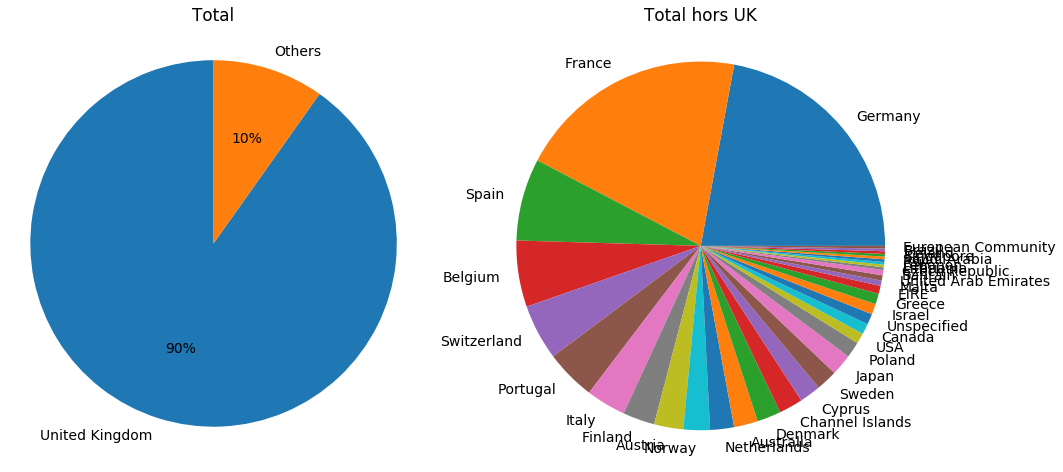

In [16]:
plt.rc('font', weight='normal', size=14)

fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(121)
nbUK = df_country[df_country.Country=='United Kingdom'].CustomerID.sum()
nbOthers = df_country[df_country.Country!='United Kingdom'].CustomerID.sum()
ax.pie([nbUK, nbOthers], labels=['United Kingdom', 'Others'], autopct = lambda x:'{:1.0f}%'.format(x), startangle=90)
ax.axis('equal')
plt.title('Total')

ax = fig.add_subplot(122)
df_country_others = df_country[df_country.Country!='United Kingdom']
ax.pie(df_country_others.CustomerID, labels=df_country_others.Country)
ax.axis('equal')
plt.title('Total hors UK')
plt.show()

Comme on peut le voir les achat en provenance de UK sont très majoritaires.

On va simplifier cette donnée par la feature 'UK' valant 1 pour un achat en provenance du Royaume Uni et 0 sinon. Cela va permettre de différencier deux types de clients uniquement

In [17]:
df['UK'] = 1
df.loc[df.Country != 'United Kingdom', 'UK'] = 0

### 2.5 Prix total

Pour chaque ligne on peut ajouter le prix total, ce qui va nous permettre d'estimer les montants dépensés par chaque client

In [18]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0,1,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0,1,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34


### 2.6 Codes

Les codes ne correspondent pas tous à des produits, certains commençant par une lettre désignent différents types de transactions, commençons par les lister:

In [19]:
lst_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na=False)==True]['StockCode'].unique()
for code in lst_codes:
    display(df[df.StockCode == code].head())


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.0,12583.0,France,0,0,0,54.0
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.0,12791.0,Netherlands,0,0,0,15.0
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.0,12662.0,Germany,0,0,0,18.0
5073,536840,POST,POSTAGE,1,2010-12-02 18:27:00,18.0,12738.0,Germany,0,0,0,18.0
5258,536852,POST,POSTAGE,1,2010-12-03 09:51:00,18.0,12686.0,France,0,0,0,18.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,1,0,1,-27.50
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom,1,0,1,-29.29
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom,1,0,1,-281.00
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom,1,0,1,-267.12
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom,1,0,1,-5.76


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.0,14911.0,EIRE,0,0,0,50.0
12119,537368,C2,CARRIAGE,1,2010-12-06 12:40:00,50.0,14911.0,EIRE,0,0,0,50.0
12452,537378,C2,CARRIAGE,1,2010-12-06 13:06:00,50.0,14911.0,EIRE,0,0,0,50.0
19975,537963,C2,CARRIAGE,1,2010-12-09 11:30:00,50.0,13369.0,United Kingdom,0,0,1,50.0
20016,538002,C2,CARRIAGE,1,2010-12-09 11:48:00,50.0,14932.0,Channel Islands,0,0,0,50.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
2239,536569,M,Manual,1,2010-12-01 15:35:00,1.25,16274.0,United Kingdom,0,0,1,1.25
2250,536569,M,Manual,1,2010-12-01 15:35:00,18.95,16274.0,United Kingdom,0,0,1,18.95
6798,536981,M,Manual,2,2010-12-03 14:26:00,0.85,14723.0,United Kingdom,0,0,1,1.70
7976,537077,M,Manual,12,2010-12-05 11:59:00,0.42,17062.0,United Kingdom,0,0,1,5.04
8530,537137,M,Manual,36,2010-12-05 12:43:00,0.85,16327.0,United Kingdom,0,0,1,30.60


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
4406,536779,BANK CHARGES,Bank Charges,1,2010-12-02 15:08:00,15.0,15823.0,United Kingdom,0,0,1,15.0
62508,541505,BANK CHARGES,Bank Charges,1,2011-01-18 15:58:00,15.0,15939.0,United Kingdom,0,0,1,15.0
152966,549717,BANK CHARGES,Bank Charges,1,2011-04-11 14:56:00,15.0,14606.0,United Kingdom,0,0,1,15.0
175275,551945,BANK CHARGES,Bank Charges,1,2011-05-05 11:09:00,15.0,16714.0,United Kingdom,0,0,1,15.0
327921,565735,BANK CHARGES,Bank Charges,1,2011-09-06 12:25:00,15.0,16904.0,United Kingdom,0,0,1,15.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-04-15 09:27:00,0.001,13952.0,United Kingdom,0,0,1,0.001
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-07-26 10:13:00,0.001,15618.0,United Kingdom,0,0,1,0.001
358655,568158,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 12:22:00,0.000,16133.0,United Kingdom,0,1,1,0.000
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2011-09-25 14:58:00,0.001,16198.0,United Kingdom,0,0,1,0.001


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
317507,564764,DOT,DOTCOM POSTAGE,1,2011-08-30 10:49:00,11.17,14096.0,United Kingdom,0,0,1,11.17
324002,565383,DOT,DOTCOM POSTAGE,1,2011-09-02 15:45:00,16.46,14096.0,United Kingdom,0,0,1,16.46
333755,566217,DOT,DOTCOM POSTAGE,1,2011-09-09 15:17:00,13.16,14096.0,United Kingdom,0,0,1,13.16
338829,566566,DOT,DOTCOM POSTAGE,1,2011-09-13 12:32:00,85.58,14096.0,United Kingdom,0,0,1,85.58
350599,567656,DOT,DOTCOM POSTAGE,1,2011-09-21 14:40:00,878.55,14096.0,United Kingdom,0,0,1,878.55


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice
317508,C564763,CRUK,CRUK Commission,-1,2011-08-30 10:49:00,1.60,14096.0,United Kingdom,1,0,1,-1.60
324023,C565382,CRUK,CRUK Commission,-1,2011-09-02 15:45:00,13.01,14096.0,United Kingdom,1,0,1,-13.01
333779,C566216,CRUK,CRUK Commission,-1,2011-09-09 15:17:00,15.96,14096.0,United Kingdom,1,0,1,-15.96
338848,C566565,CRUK,CRUK Commission,-1,2011-09-13 12:32:00,52.24,14096.0,United Kingdom,1,0,1,-52.24
351003,C567655,CRUK,CRUK Commission,-1,2011-09-21 14:40:00,608.66,14096.0,United Kingdom,1,0,1,-608.66


### 2.6.1 Code POST

In [20]:
code = 'POST'
df[df.StockCode == code].Country.unique()

array(['France', 'Netherlands', 'Germany', 'Switzerland', 'Portugal',
       'Italy', 'Belgium', 'United Kingdom', 'Denmark', 'Spain', 'Finland',
       'Austria', 'Sweden', 'Norway', 'Cyprus', 'Australia', 'Greece',
       'European Community', 'Poland', 'Malta', 'Canada',
       'United Arab Emirates', 'Czech Republic'], dtype=object)

Le code POST correspond à des frais postaux, il y en a même en UK, on peut l'utiliser comme nouvelle feature

In [21]:
df['CODE_' + code] = 0
df.loc[df.StockCode == code, 'CODE_' + code] = 1

### 2.6.2 Code D

In [22]:
code = 'D'
print(df[(df.StockCode == code)].shape)
print(df[(df.StockCode == code) & (df['InvoiceNo'].str.startswith('C', na=False))].shape)

(77, 13)
(77, 13)


Le code D correspond à du discount, ils sont déjà tous noté 'Cancel' mais n'en forment qu'une petite partie, on va là aussi créer une nouvelle feature

In [23]:
df['CODE_' + code] = 0
df.loc[df.StockCode == code, 'CODE_' + code] = 1

### 2.6.3 Code C2

Le code C2 (pour CARRIAGE) semble être une sorte de frais de transport, gardons le

In [24]:
code = 'C2'
df['CODE_' + code] = 0
df.loc[df.StockCode == code, 'CODE_' + code] = 1

### 2.6.4 Code M

Le code M (pour MANUAL) semble être une sorte de frais de transport aussi, gardons

In [25]:
code = 'M'
df['CODE_' + code] = 0
df.loc[df.StockCode == code, 'CODE_' + code] = 1

### 2.6.5 Code BANK CHARGES

Trop peu d'occurrences

### 2.6.6 Code PADS

Le code PADS ne concerne que 4 lignes, pour des sommes dérisoires, il ne semble pas utile de s'en occuper à notre niveau

### 2.6.7 Code DOT

DOT (pour DOTCOM POSTAGE) : trop peu d'occurrences

### 2.6.8 Code CRUK

Le code CRUK (Cancer Research UK commission) correspond à des sommes données en faveur de la recherche contre le cancer, cette feature est intéressante pour caractériser un client, le problème est qu'elle ne concerne qu'un seul client ! Pas d'intérêt pour nous donc  :(

## 3. Regroupement des features par client

### 3.1 Création de la table RFM

La table RFM (récence, fréquence, valeur) est la base de la segmentation client, elle permet de catégoriser les clients selon des critères simples, le client est-il nouveau, est-il régulier ? Dépense-t-il beacoup d'argent ? ...

On va utiliser une méthode de construction de cette table RFM que l'on pourra rejouer en envoyant des données filtrées sur une période donnée par exemple.

On ajoute aussi les nouvelles feature vues précédemment.

In [26]:
# Calcul du quartile de récence
def getRScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Calcul du quartile de fréquence et de montant
def getFMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Méthode de création d'un table RFM à partir d'un dataframe
def getRFM(p_df):
    # Référence pour calculer la récence
    # On prends la dernière date du dataframe et on ajoute un jour
    dtmax = p_df.InvoiceDate.max()
    NOW = dt.datetime(dtmax.year, dtmax.month, dtmax.day) + dt.timedelta(days=1)
    print('Date de référence :', NOW)

    ret = p_df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max()).days, 
                                         'InvoiceNo': lambda x: len(x), 
                                         'TotalPrice': lambda x: x.sum(),
                                         'Cancel': lambda x: x.sum(),
                                         'Promo': lambda x: x.sum(),
                                         'UK': lambda x: 1 if (x.all()>0) else 0,
                                         'CODE_POST': lambda x: x.sum(),
                                         'CODE_D': lambda x: x.sum(),
                                         'CODE_C2': lambda x: x.sum(),
                                         'CODE_M': lambda x: x.sum(),
                                                        })
    # Un prix total négatif correspond certainement à des retours clients dont l'achat n'était pas dans la base, on le met à 0
    ret.loc[ret.TotalPrice < 0, 'TotalPrice'] = 0
    # La date est maintenant un nombre de jours
    ret['InvoiceDate'] = ret['InvoiceDate'].astype(int)
    # On peut renommer les colonnes pour plus de clarté
    ret.rename(columns = {'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value',
                         'CODE_D': 'CODE_DISCOUNT',
                         'CODE_C2': 'CODE_CARRIAGE',
                         'CODE_M': 'CODE_MANUAL',
                         }, inplace=True)
    
    quantiles = ret.quantile(q=[0.25,0.5,0.75])
    quantiles = quantiles.to_dict()
    
    ret['r_quartile'] = ret['recency'].apply(getRScore, args=('recency',quantiles))
    ret['f_quartile'] = ret['frequency'].apply(getFMScore, args=('frequency',quantiles))
    ret['m_quartile'] = ret['monetary_value'].apply(getFMScore, args=('monetary_value',quantiles))

    ret['RFMScore'] = ret.r_quartile.map(str) + ret.f_quartile.map(str) + ret.m_quartile.map(str)

    return ret

In [27]:
# Création de la table RFM sur l'ensemble de nos données
rfmTable = getRFM(df)
display(rfmTable.head())
rfmTable.describe()

Date de référence : 2011-12-10 00:00:00


,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,,,,,,,
12346.0,325,2,0.00,1,0,1,0,0,0,0,4,4,4,444
12347.0,2,182,4310.00,0,0,0,0,0,0,0,1,1,1,111
12348.0,75,31,1797.24,0,0,0,4,0,0,0,3,3,1,331
12349.0,18,73,1757.55,0,0,0,1,0,0,0,2,2,1,221
12350.0,310,17,334.40,0,0,0,1,0,0,0,4,4,3,443


,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,91.581199,93.053294,1901.485580,2.036825,0.009149,0.903477,0.273559,0.017612,0.030650,0.106359,2.489021,2.512580,2.500000
std,100.772139,232.471608,8218.276346,7.340449,0.126218,0.295341,1.449589,0.558957,1.305348,0.655397,1.117084,1.119114,1.118162
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,16.000000,17.000000,293.362500,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.750000
50%,50.000000,42.000000,648.075000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.500000
75%,143.000000,102.000000,1611.725000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,4.000000,3.250000
max,373.000000,7983.000000,279489.020000,226.000000,4.000000,1.000000,33.000000,35.000000,85.000000,17.000000,4.000000,4.000000,4.000000


### 3.2 Analyse de la table RFM

#### 3.2.1 Les meilleurs clients selon la table RFM

Les meilleurs clients ont un score de 111, en effet il ne suffit pas d'avoir fait une très grosse commande pour être parmi les meilleurs clients, encore faut-il revenir fréquemment et régulièrement

In [28]:
# Les meilleurs clients
rfmTable[rfmTable['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(20)

,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,,,,,,,,
14646.0,1,2085,279489.02,5,4,0,17,1,0,1,1,1,1,111
18102.0,0,433,256438.49,2,0,1,0,0,0,2,1,1,1,111
17450.0,8,351,187482.17,14,0,1,6,1,0,4,1,1,1,111
14911.0,1,5903,132572.62,226,2,0,0,1,85,4,1,1,1,111
14156.0,9,1420,113384.14,20,0,0,0,0,13,1,1,1,1,111
17511.0,2,1076,88125.38,113,0,1,1,0,0,1,1,1,1,111
16684.0,4,281,65892.08,4,0,1,0,1,0,0,1,1,1,111
13694.0,3,585,62653.10,17,0,1,0,2,0,1,1,1,1,111
15311.0,0,2491,59419.34,112,0,1,0,0,0,0,1,1,1,111


#### 3.2.2 Les meilleurs clients selon le chiffre d'affaire

Voyons un peu ce que donne le principe de Pareto ici. Il énonce que 80% des effets sont le produit de 20% des causes.

Je vais chercher en parcourant le pourcentage cumulé du chiffre d'affaire une proportion parlante des meilleurs clients produisant une valeur conséquante du CA

439 clients apportent 60% du CA


Text(1000,50,'10% des clients, 60% du CA')

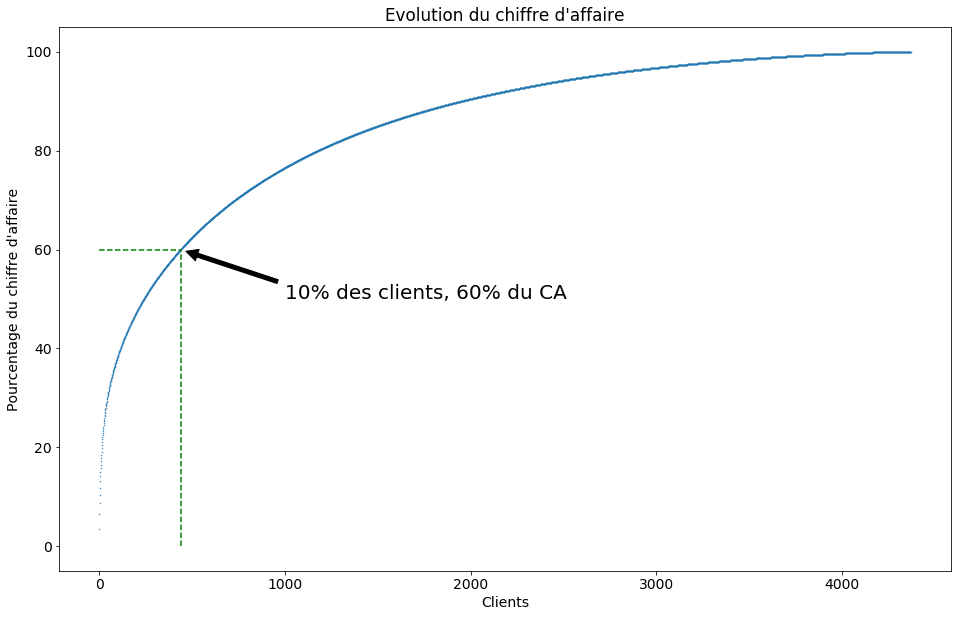

In [29]:
# Recherche des plus gros apporteurs de chiffre
rfmBest = rfmTable.copy()
rfmBest = rfmBest.sort_values('monetary_value', ascending=False)
rfmBest['cum_sum'] = rfmBest.monetary_value.cumsum()
rfmBest['cum_perc'] = 100 * rfmBest.cum_sum / rfmBest.monetary_value.sum()

nb_best_customers = rfmBest[rfmBest['cum_perc']<60].shape[0]

print(nb_best_customers, 'clients apportent 60% du CA')

# 60% du CA par 10% des clients (à peu près 400)

fig, ax = plt.subplots(figsize=(16,10))
plt.scatter(range(0, len(rfmBest['cum_sum'])), rfmBest['cum_perc'], s=0.2)
plt.plot((0, nb_best_customers), (60, 60), '--', c='g')
plt.plot((nb_best_customers, nb_best_customers), (0, 60), '--', c='g')
plt.xlabel("Clients")
plt.ylabel("Pourcentage du chiffre d'affaire")
plt.title("Evolution du chiffre d'affaire")
plt.annotate('10% des clients, 60% du CA', xy=(nb_best_customers, 60), xytext=(1000, 50), fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

Comme dans la plupart des cas, une grosse partie du CA est apportée par une petite partie des clients.

Ce graphique est intéressant visuellement mais tous ces clients sont déjà catégorisé par la table RFM, on n'ajoutera donc pas de nouvelle feature ici.

#### 3.2.3 Visualisation 3D

On va essayer de visualiser ces données en 3D, pour cela on doit prendre le log des prix pour réduire l'échelle.

Text(0.5,0,'Valeur (log)')

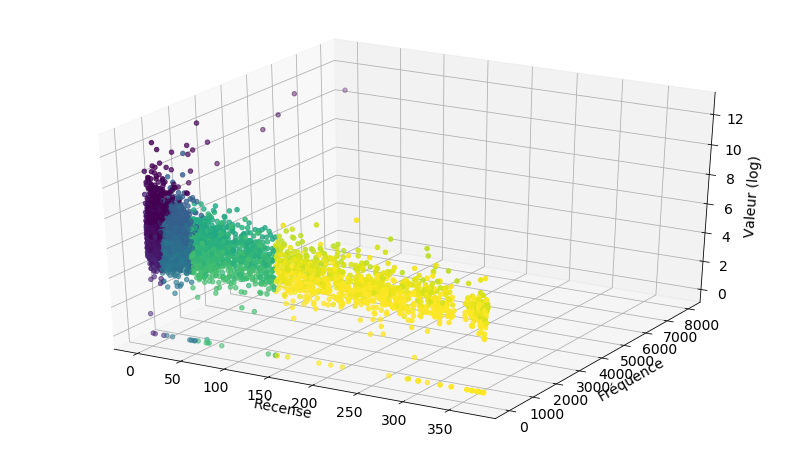

In [30]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection='3d')
ax.scatter(rfmTable.recency, rfmTable.frequency, np.log(rfmTable.monetary_value+1), c=rfmTable.RFMScore)
plt.ylabel('Fréquence')
plt.xlabel('Récense')
ax.set_zlabel('Valeur (log)')
#plt.gca().invert_xaxis()
#plt.gca().invert_yaxis()

#### 3.2.4 ACP et Scree plot

Procédons maintenant à une analyse en composantes principales de la table RFM.

Dans un premier temps j'ai besoin d'une méthode pour entrainer une PCA, puis faire un graphique de la variance cumulée et afficher nos données projetées sur les deux principales composantes.

Et enfin si le nombre de composantes le permet j'affiche la contribution de chaque variable aux composantes principales.

In [31]:
def displayPCA(p_df):
    X_scaled = StandardScaler().fit_transform(p_df.fillna(0))

    pca = PCA(n_components=None)
    pca.fit(X_scaled)
    nbvar = len(pca.explained_variance_ratio_) +1

    fig, ax = plt.subplots(figsize=(16, 8))
    plt.bar(range(1,nbvar), pca.explained_variance_ratio_, alpha = 0.5, align = 'center', label = 'individual explained variance')
    plt.step(range(1,nbvar), np.cumsum(pca.explained_variance_ratio_), where = 'mid', label = 'cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc = 'best')
    plt.title('Variance cumulée', fontsize=18)
    plt.show()
    print("Deux composantes nous permettent d'expliquer %i pourcent de la variance" % (np.cumsum(pca.explained_variance_ratio_[:2])[1]*100))
    print('\n')
    
    # projeter X sur les composantes principales
    X_projected = pca.transform(X_scaled)
    # afficher chaque observation
    fig = plt.figure(figsize=(16, 10))
    plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable 'RFMScore'
    c = rfmTable.get('RFMScore'))
    plt.xlim([-5.5, 5.5])
    plt.ylim([-4, 4])
    plt.colorbar()
    plt.title('Projection sur les composantes principales', fontsize=18)
    plt.show()

    # S'il y a trop de feature on n'affichage pas ce dernier graphe qui sera illisible
    if nbvar > 15: return
    print('\n')
    pcs = pca.components_
    fig = plt.figure(figsize=(16, 10))
    for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
        # Afficher un segment de l'origine au point (x, y)
        plt.plot([0, x], [0, y], color='k')
        # Afficher le nom (data.columns[i]) de la performance
        plt.text(x, y, p_df.columns[i], fontsize='18')
    # Afficher une ligne horizontale y=0
    plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')
    # Afficher une ligne verticale x=0
    plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')
    plt.xlim([-0.7, 0.7])
    plt.ylim([-0.7, 0.7])
    plt.title('Contribution de chaque variable aux composantes principales', fontsize=18)
    plt.show()

    return

Index(['recency', 'frequency', 'monetary_value', 'Cancel', 'Promo', 'UK',
       'CODE_POST', 'CODE_DISCOUNT', 'CODE_CARRIAGE', 'CODE_MANUAL',
       'r_quartile', 'f_quartile', 'm_quartile'],
      dtype='object')


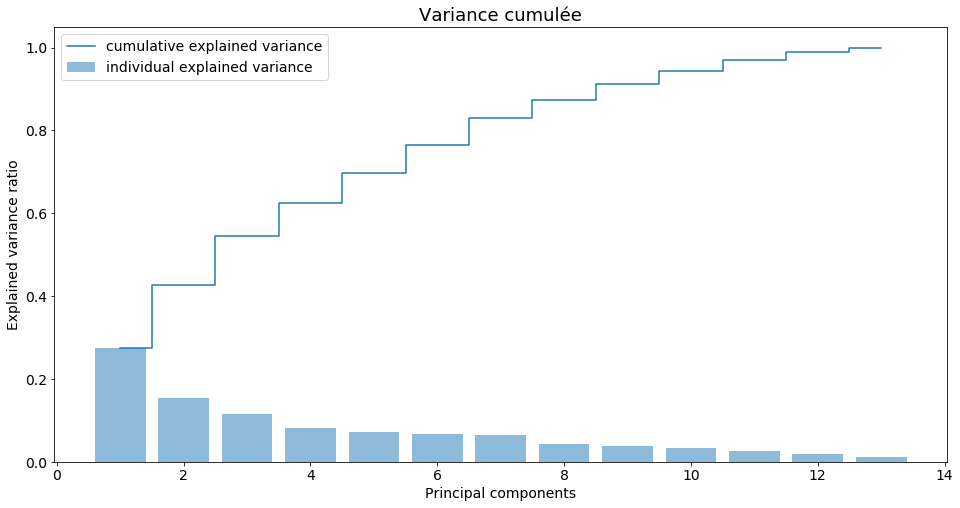

Deux composantes nous permettent d'expliquer 42 pourcent de la variance




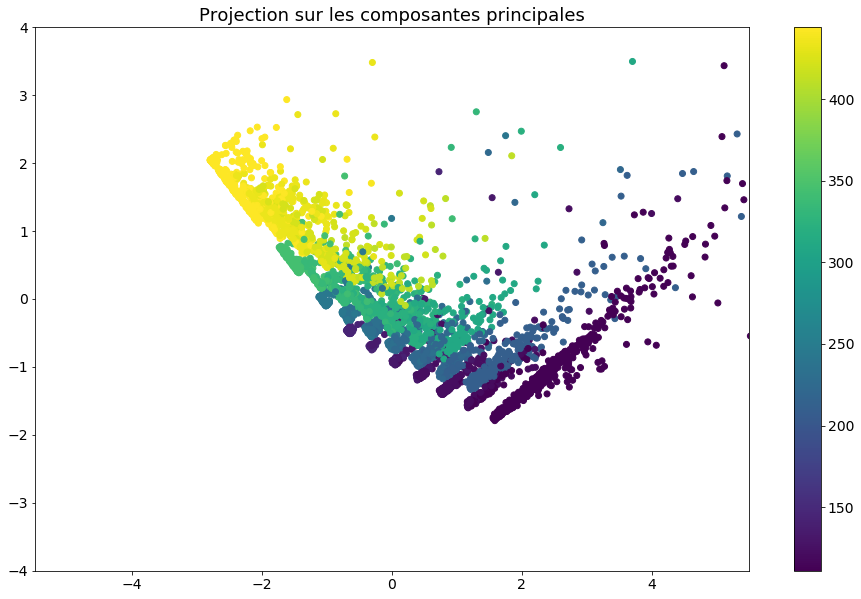

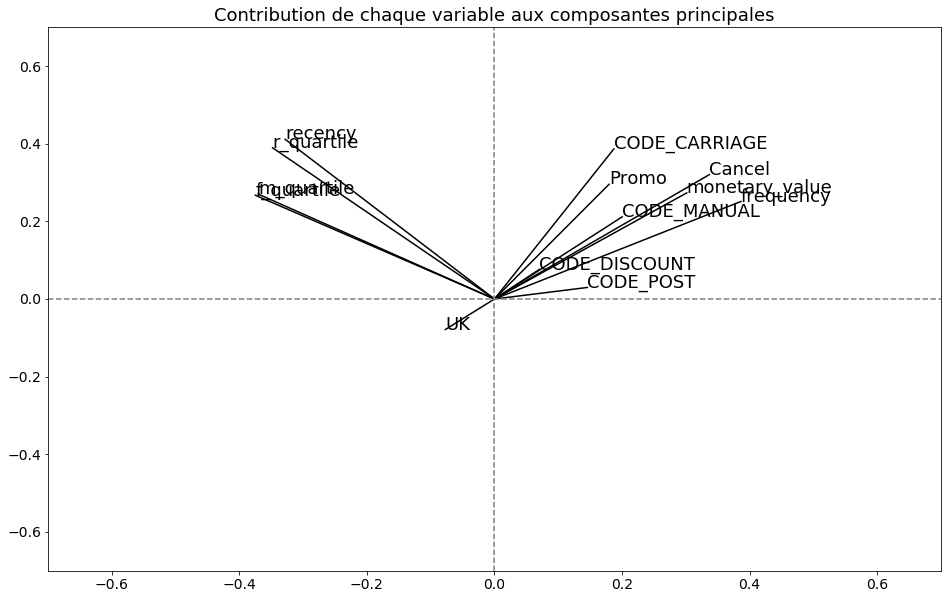

In [32]:
# En tant que feature le RFMScore ne nous apporte rien car il est la concaténation de 3 features existantes, on peut donc s'en passer
rfmPCA = rfmTable.copy()
rfmPCA.pop('RFMScore')
print (rfmPCA.columns)

displayPCA(rfmPCA)

On arrive au dessus de 80% de variance expliquée à partir de 7 composantes, et à partir de là, chaque composante supplémentaire apporte moins de 5% d'explication de variance en plus.

## 4. Historique des achats par client

L'idée ici est d'avoir des données pour chaque client mois par mois, des données concernant la quantité de produits achetés ainsi que le prix total dépensé. On utilisera le minimum, le maximum et la moyenne pour chacun.

On ajoute donc dans un premier temps une colonne représentant le mois de la facture

In [33]:
pd.set_option('display.max_columns', 150)
df['InvoiceDateM'] = df['InvoiceDate'].dt.month
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancel,Promo,UK,TotalPrice,CODE_POST,CODE_D,CODE_C2,CODE_M,InvoiceDateM
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0,1,15.30,0,0,0,0,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34,0,0,0,0,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0,1,22.00,0,0,0,0,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34,0,0,0,0,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0,1,20.34,0,0,0,0,12


In [34]:
# On va aggréger selon ces features:
aggreg = {
    'Quantity':[
        'sum',
        'max',
        'min'
    ],
    'TotalPrice':[
        'sum',
        'max',
        'min'
    ]
}

# Aggrégation
dfhisto = df.groupby(['CustomerID', 'InvoiceDateM']).agg(aggreg).unstack()
print(dfhisto.shape)
dfhisto = dfhisto.fillna(0)
dfhisto.head()

(4372, 72)


Quantity                                                    \
                  sum                                                     
InvoiceDateM       1      2    3      4    5      6    7      8      9    
CustomerID                                                                
12346.0           0.0    0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0   
12347.0         315.0    0.0  0.0  483.0  0.0  196.0  0.0  277.0    0.0   
12348.0         601.0    0.0  0.0  269.0  0.0    0.0  0.0    0.0  217.0   
12349.0           0.0    0.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0   
12350.0           0.0  197.0  0.0    0.0  0.0    0.0  0.0    0.0    0.0   

                                                                               \
                                        max                                     
InvoiceDateM     10     11      12       1     2    3      4    5     6    7    
CustomerID                                                                      
12346.0         0.0    0.0     0.0  74215.0   0.0  0.0    0.0  0.0   0.0  0.0   
12347.0       676.0    0.0   511.0     24.0   0.0  0.0  240.0  0.0  36.0  0.0   
12348.0         0.0    0.0  1254.0    144.0   0.0  0.0   96.0  0.0   0.0  0.0   
12349.0         0.0  631.0     0.0      0.0   0.0  0.0    0.0  0.0   0.0  0.0   
12350.0         0.0    0.0     0.0      0.0  24.0  0.0    0.0  0.0   0.0  0.0   

                                                                           \
                                                  min                       
InvoiceDateM    8      9     10    11     12       1    2    3    4    5    
CustomerID                                                                  
12346.0        0.0    0.0   0.0   0.0    0.0 -74215.0  0.0  0.0  0.0  0.0   
12347.0       36.0    0.0  48.0   0.0   36.0      3.0  0.0  0.0  3.0  0.0   
12348.0        0.0  120.0   0.0   0.0  144.0      1.0  0.0  0.0  1.0  0.0   
12349.0        0.0    0.0   0.0  36.0    0.0      0.0  0.0  0.0  0.0  0.0   
12350.0        0.0    0.0   0.0   0.0    0.0      0.0  1.0  0.0  0.0  0.0   

                                                TotalPrice              \
                                                       sum               
InvoiceDateM   6    7    8    9    10   11   12         1      2    3    
CustomerID                                                               
12346.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.00    0.0  0.0   
12347.0       2.0  0.0  3.0  0.0  2.0  0.0  3.0     475.39    0.0  0.0   
12348.0       0.0  0.0  0.0  1.0  0.0  0.0  6.0     227.44    0.0  0.0   
12349.0       0.0  0.0  0.0  0.0  0.0  1.0  0.0       0.00    0.0  0.0   
12350.0       0.0  0.0  0.0  0.0  0.0  0.0  0.0       0.00  334.4  0.0   

                                                                         \
                                                                          
InvoiceDateM      4    5       6    7       8      9        10       11   
CustomerID                                                                
12346.0         0.00  0.0    0.00  0.0    0.00    0.0     0.00     0.00   
12347.0       636.25  0.0  382.52  0.0  584.91    0.0  1294.32     0.00   
12348.0       367.00  0.0    0.00  0.0    0.00  310.0     0.00     0.00   
12349.0         0.00  0.0    0.00  0.0    0.00    0.0     0.00  1757.55   
12350.0         0.00  0.0    0.00  0.0    0.00    0.0     0.00     0.00   

                                                                         \
                           max                                            
InvoiceDateM      12        1     2    3      4    5     6    7      8    
CustomerID                                                                
12346.0         0.00  77183.60   0.0  0.0    0.0  0.0   0.0  0.0    0.0   
12347.0       936.61     38.25   0.0  0.0  249.6  0.0  53.1  0.0  106.2   
12348.0       892.80     41.76   0.0  0.0  120.0  0.0   0.0  0.0    0.0   
12349.0         0.00      0.00   0.0  0.0    

On peut en profiter pour regarder ce que donne une PCA sur cette table d'historique.

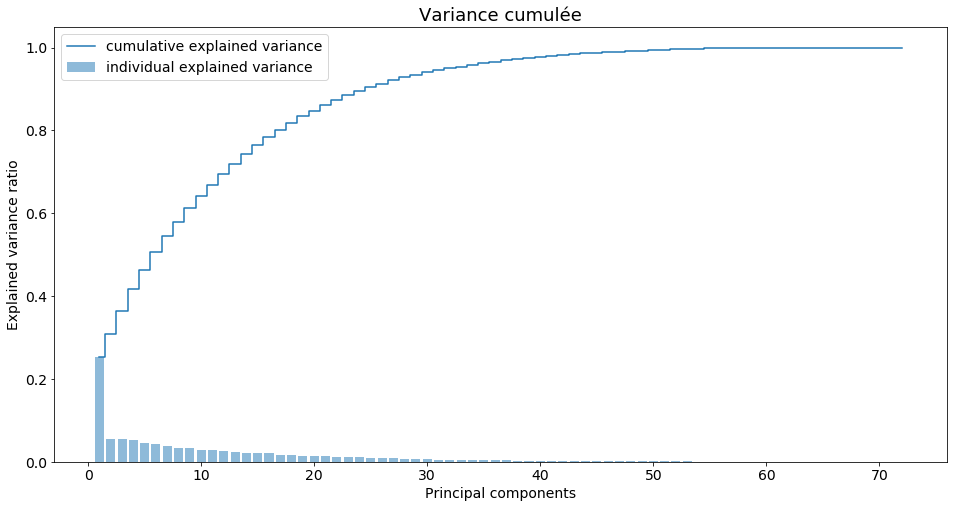

Deux composantes nous permettent d'expliquer 30 pourcent de la variance




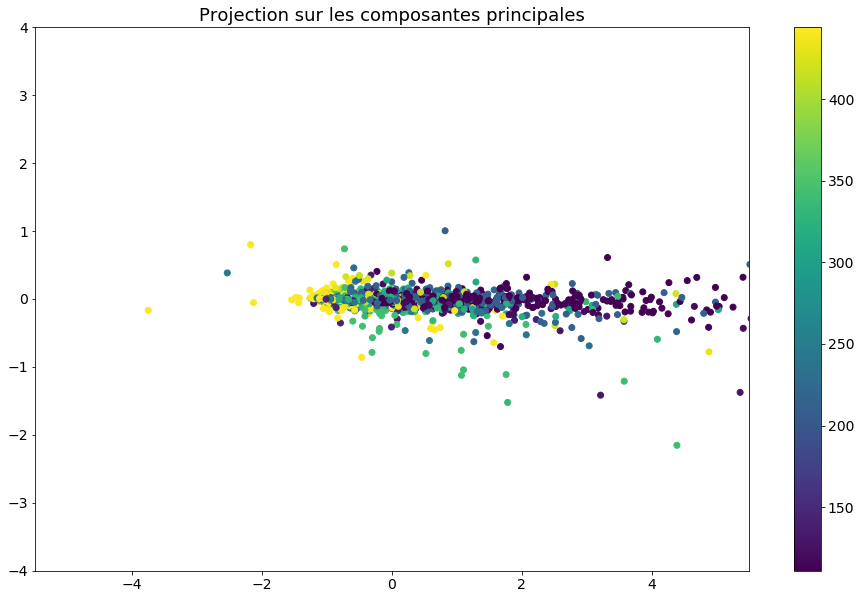

In [35]:
displayPCA(dfhisto)

Il y a trop de composantes pour que l'on puisse tirer des explications de ces graphes.

## 5. Ensemble des features

Maintenant on va réunir toutes les données que l'on possède sur chaque client en une seule table, que l'on va pouvoir analyser de la même manière que précédemment.

In [36]:
# Ajout des données temporelles aux données RFM
dfTotale = pd.concat([rfmPCA, dfhisto], axis=1)

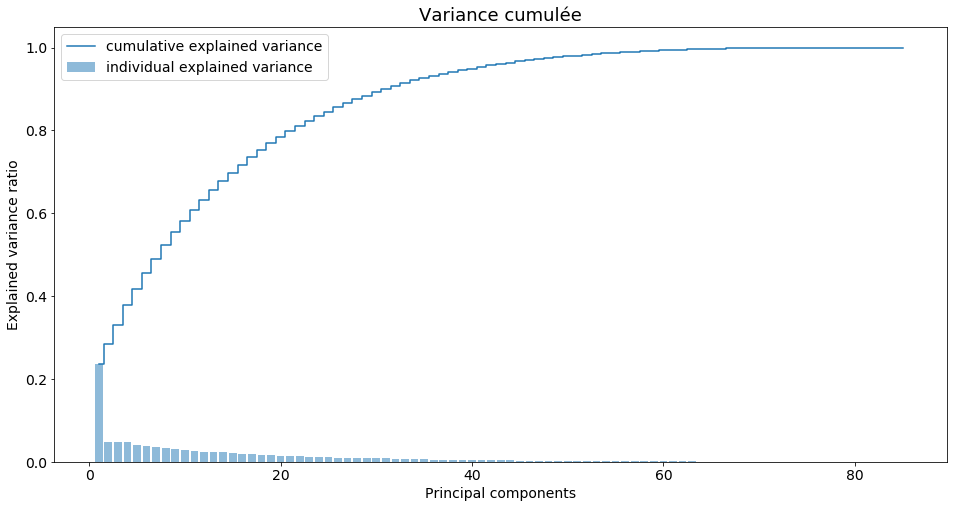

Deux composantes nous permettent d'expliquer 28 pourcent de la variance




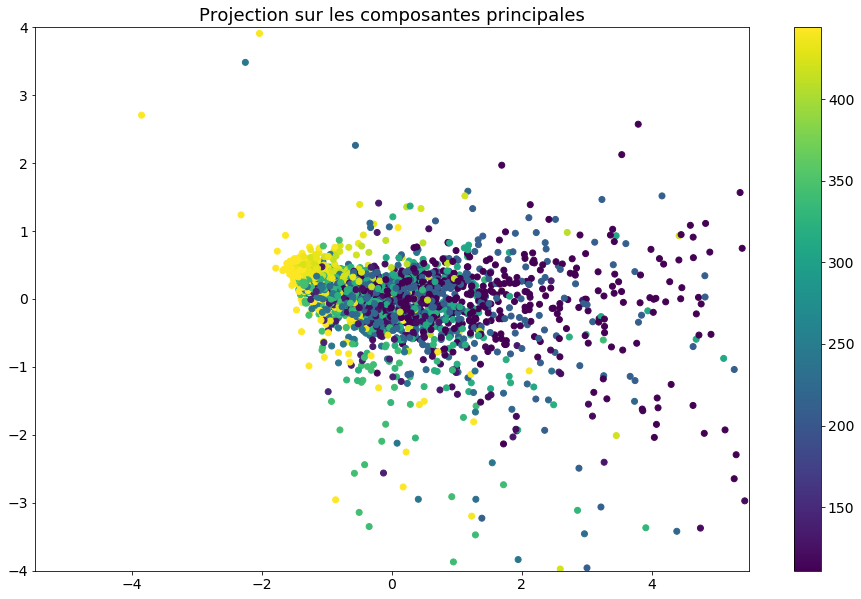

In [37]:
displayPCA(dfTotale)

Logiquement il y a trop de composantes pour que l'on puisse tirer des explications de ces graphes.

## 6 Coefficients de silhouette

Je vais d'abord créer une méthode qui va me permettre de comparer la création de clusters de deux manières différentes, l'une hiérarchique par aggrégation (le clustering de Ward), l'autre heuristique (algorithme de Lloyd, le K-Means).

On peut imaginer qu'un directeur commercial ou marketing veuille pouvoir segmenter ses clients en un nombre qui soit gérable et compréhensible, il ne semble donc pas utile de chercher à faire plus de 15 groupes de clients différents, au delà il devient compliqué de gérer des campagnes de ciblage par exemple.

Je vais donc parcourir un nombre de clusters jusqu'à une quinzaine et voir si un découpage se détache.

Je vais faire ces tests sur différents groupes de features.

In [38]:
def displaySilhouette(p_df):
    #print(p_df.columns)
    X_scaled = MinMaxScaler().fit_transform(p_df.fillna(0))

    silKMeans = []
    silAgg = []
    lstclust = range(2, 16)
    for nu in lstclust:
        cls = cluster.KMeans(n_clusters=nu, n_init=100, init='k-means++')
        cls.fit(X_scaled)
        silKMeans.append(silhouette_score(X_scaled, cls.labels_))

        cls = cluster.AgglomerativeClustering(n_clusters=nu, linkage='ward')
        cls.fit(X_scaled)
        silAgg.append(silhouette_score(X_scaled, cls.labels_))

    # Affichage
    fig, ax = plt.subplots(figsize=(16,10))
    ax.plot(lstclust, silKMeans, marker='o', c='b', label='Kmeans')
    ax.plot(lstclust, silAgg, marker='o', c='g', label='AgglomerativeClustering')
    ax.set_xticks(lstclust)
    ax.set_xlabel('Nb clusters', fontsize=14)
    ax.set_ylabel('Coefficient de silhouette', fontsize=14)
    ax.set_title('Coefficients de silhouette en fonction du nombre de clusters', fontsize=16)
    ax.legend()
    plt.show()
    
    fig.savefig('silhouette-' + dt.datetime.now().strftime("%m-%d-%H%M") + '.png')


### 6.1 Sur des données groupées

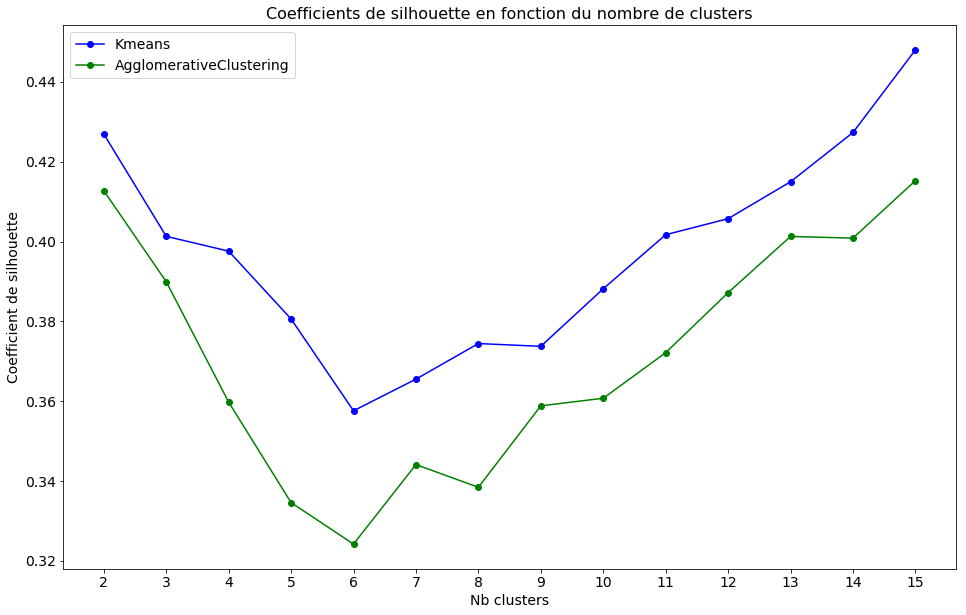

In [39]:
displaySilhouette(rfmTable[['recency', 'frequency', 'monetary_value', 'r_quartile', 'f_quartile', 'm_quartile']])

Les seules données RFM ne permettent pas de choisir k, un nombre de cluster élevé correspondant aux différentes combinaisons des features obtiendrait un bon coefficient de silhouette mais ne correspondrait pas à nos attentes.

Ajoutons simplement nos features (pays, prix total, codes)

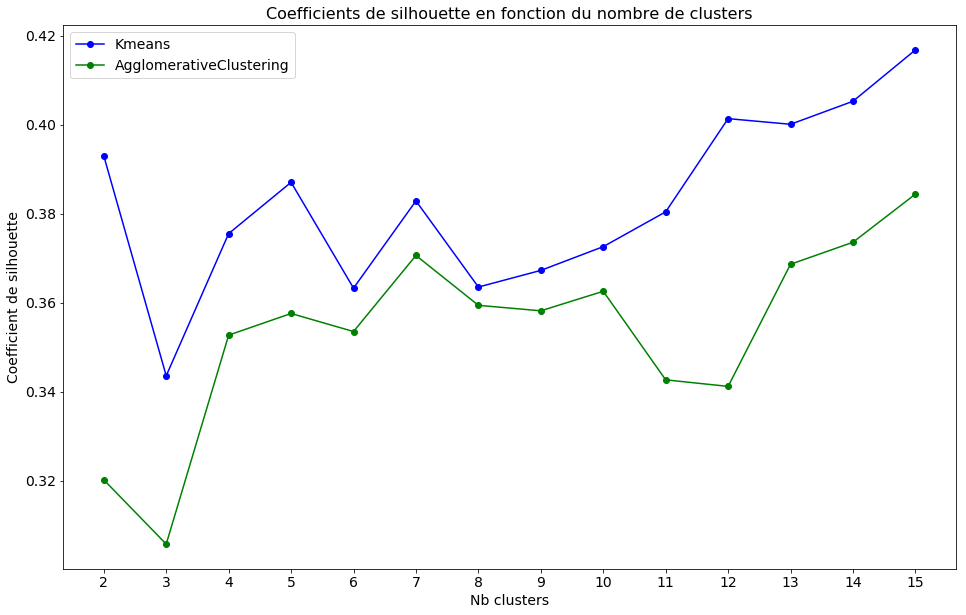

In [40]:
displaySilhouette(rfmTable)

Il y a toujours cette tendance à préférer un nombre de cluster élevé.

Regardons maintenant avec les données mensuelles seules.

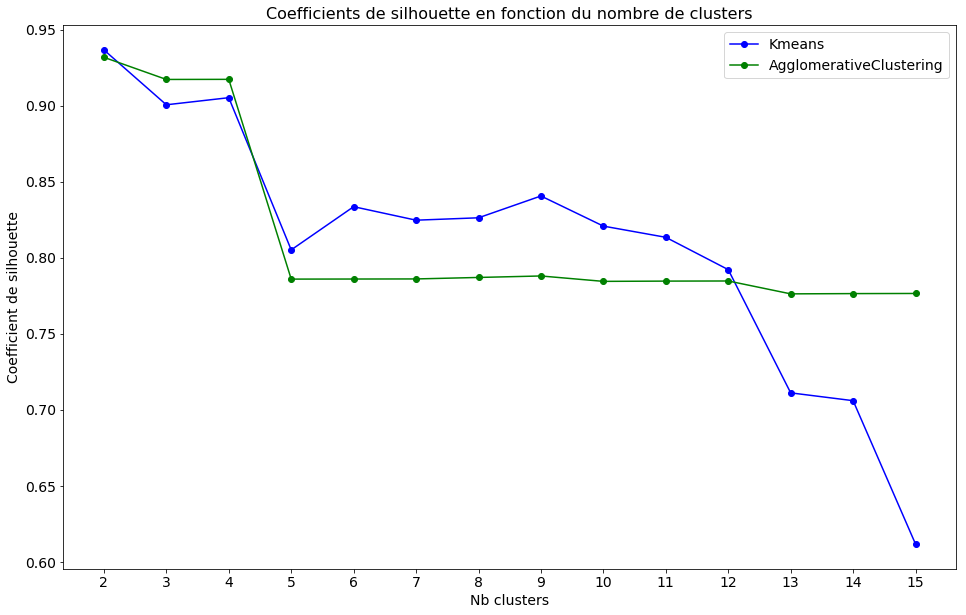

In [41]:
displaySilhouette(dfhisto)

Ne permet pas vraiment de choisir k mais va peut-être contribuer à ce que la courbe des coefficients ne soit plus croissante avec le nombre de clusters lorsque toutes les features seront ensemble.

### 6.2  Sur l'ensemble des features

On va maintenant associer les données RFM aux données historiques afin de faire une analyse complète

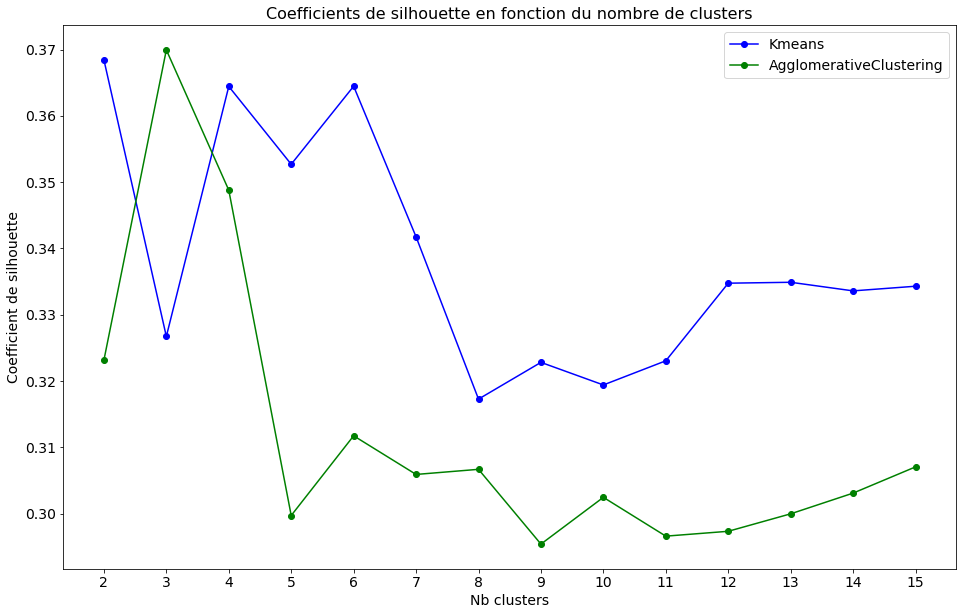

In [42]:
displaySilhouette(dfTotale)

Il semble qu'enfin on puisse raisonnablement séparer nos données avec k=6 et la méthode du k-means.

Pourquoi 6 ? On a des sommets aussi en k=2, 3 et 4 mais d'un point de vus métiers il est plus intéressant de tourner autour de 6 à 10. En effet, pour un groupe de plusieurs milliers de clients on ne peut pas se permettre de simplifier à l'extrême les catégories, ni d'en avoir plus que ce qu'on peut gérer, ça va dépendre de la taille de l'équipe marketing que l'on a (et là je suis tout seul :) ), donc 6 me parait un nombre raisonnable.

### 6.3 sur des données biaisées

3950 occurrences sur 4372


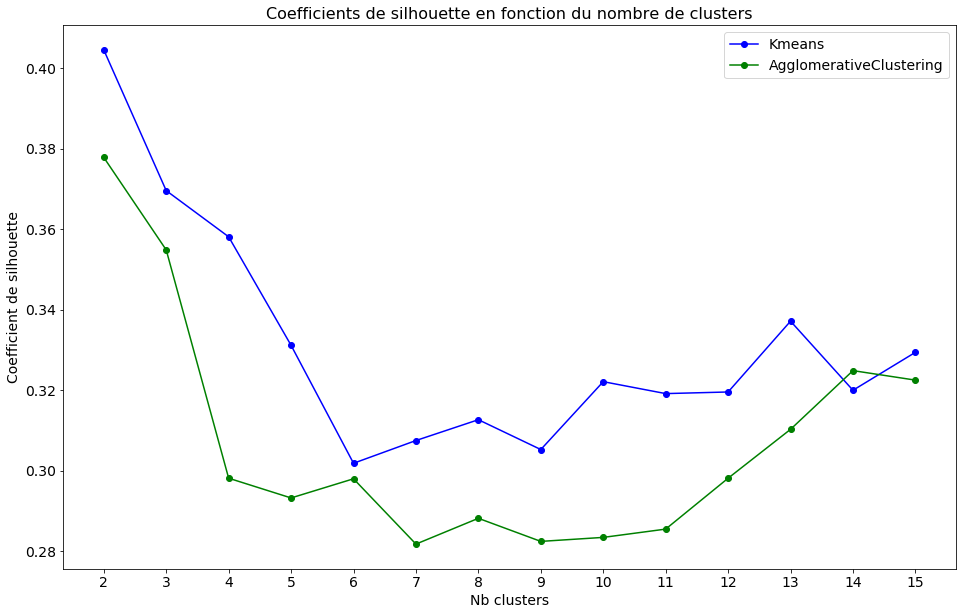

In [43]:
# Uniquement en UK
tmp = dfTotale[dfTotale.UK == 1]
print(tmp.shape[0], 'occurrences sur', dfTotale.shape[0])
displaySilhouette(tmp)

Rien de marquant ne se détache du groupe des clients UK seuls.

3707 occurrences sur 4372


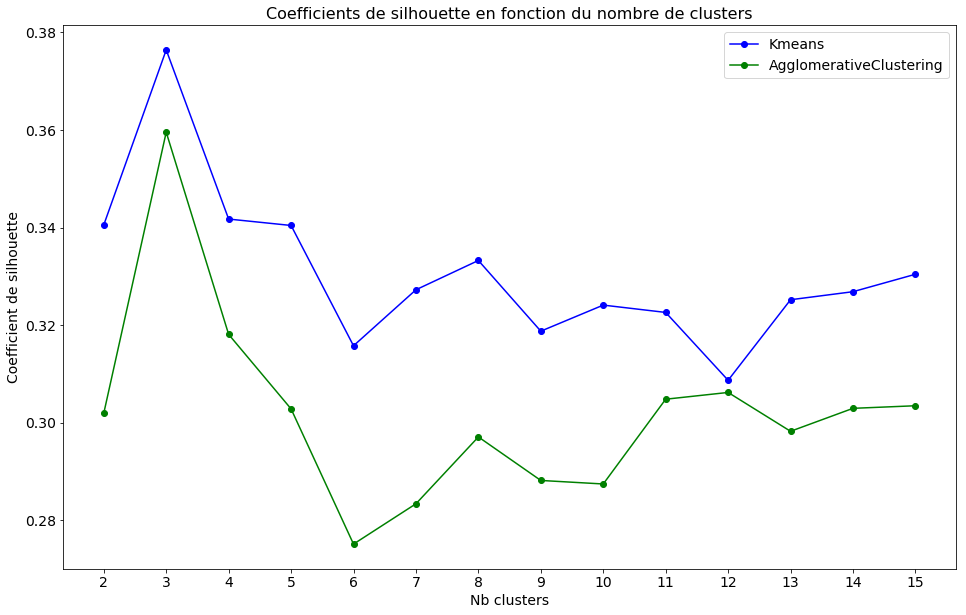

In [44]:
tmp = dfTotale[dfTotale.frequency > 10]
print(tmp.shape[0], 'occurrences sur', dfTotale.shape[0])
displaySilhouette(tmp)

Trois groupes semblent se détacher si l'on excepte les clients qui sont venus moins de 10 fois. C'est possiblement intéressant de pouvoir catégoriser en 3 nos clients les plus réguliers.

3618 occurrences sur 4372


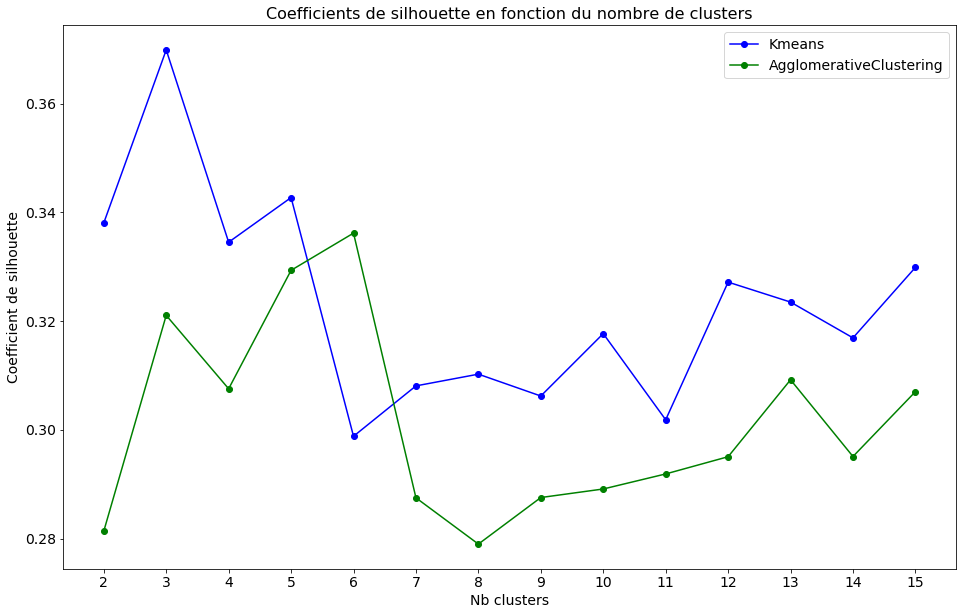

In [45]:
tmp = dfTotale[dfTotale.recency < 200]
print(tmp.shape[0], 'occurrences sur', dfTotale.shape[0])
displaySilhouette(tmp)

Idem si on ne tient pas compte des clients qui sont venus il y a très longtemps et dont on n'a plus de nouvelle. Pour les clients les plus récents donc on peut imaginer en faire 3 groupes avec un k-means, on peut aussi regarder ce que donnerait les 6 groupes du clustering agglomératif.

3659 occurrences sur 4372


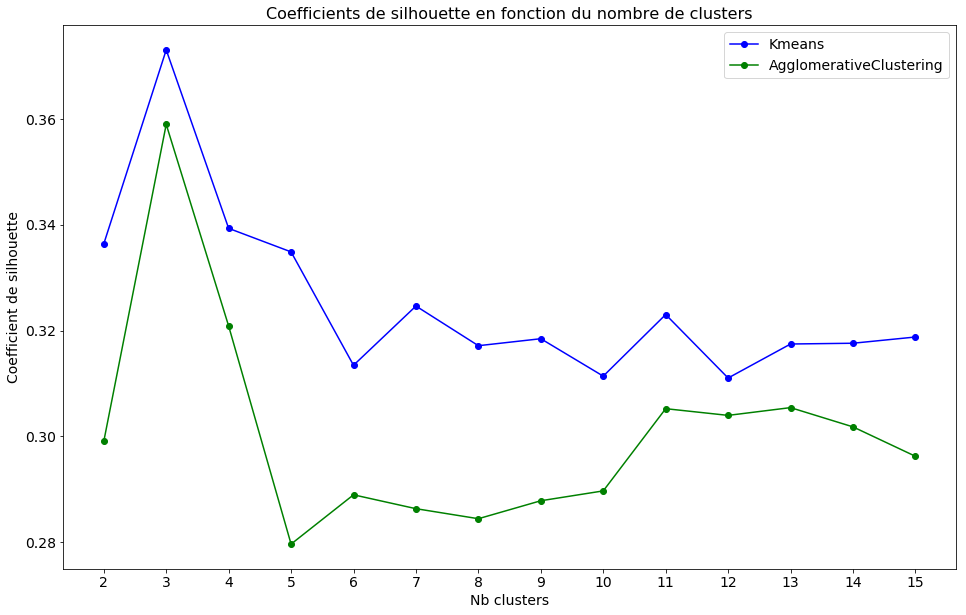

In [46]:
tmp = dfTotale[dfTotale.monetary_value > 200]
print(tmp.shape[0], 'occurrences sur', dfTotale.shape[0])
displaySilhouette(tmp)

Encore une fois, 3 groupes se détachent si l'on excepte les clients dont le panier moyen ne décolle pas.

### Attribution d'un numéro de cluster à chaque client

In [47]:
kBest = 6

cls = cluster.KMeans(n_clusters=kBest, n_init=100, init='k-means++')
X_scaled = MinMaxScaler().fit_transform(dfTotale.fillna(0))
clusters = cls.fit_predict(X_scaled)
lstclusters = pd.Series(clusters).value_counts()
lstclusters

0    1325
4    1169
1     833
2     623
3     229
5     193
dtype: int64

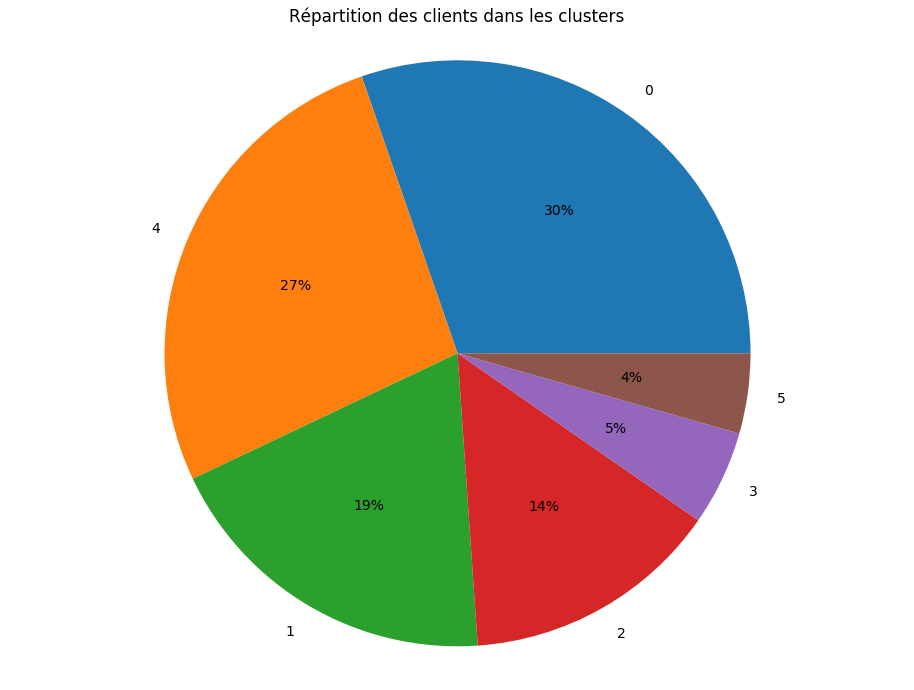

In [48]:
fig = plt.figure(figsize=(16,12))
plt.pie(lstclusters, labels=lstclusters.index, autopct = lambda x:'{:1.0f}%'.format(x))
plt.axis('equal')
plt.title('Répartition des clients dans les clusters')
plt.show()

In [49]:
liste_customers = dfTotale.index

corresp = dict()
for key, val in zip (liste_customers, clusters):
    corresp[key] = val 

dfTotale['CustomerCategory'] = dfTotale.index.to_series().map(corresp)
dfTotale.head(10)

,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile,"(Quantity, sum, 1)","(Quantity, sum, 2)","(Quantity, sum, 3)","(Quantity, sum, 4)","(Quantity, sum, 5)","(Quantity, sum, 6)","(Quantity, sum, 7)","(Quantity, sum, 8)","(Quantity, sum, 9)","(Quantity, sum, 10)","(Quantity, sum, 11)","(Quantity, sum, 12)","(Quantity, max, 1)","(Quantity, max, 2)","(Quantity, max, 3)","(Quantity, max, 4)","(Quantity, max, 5)","(Quantity, max, 6)","(Quantity, max, 7)","(Quantity, max, 8)","(Quantity, max, 9)","(Quantity, max, 10)","(Quantity, max, 11)","(Quantity, max, 12)","(Quantity, min, 1)","(Quantity, min, 2)","(Quantity, min, 3)","(Quantity, min, 4)","(Quantity, min, 5)","(Quantity, min, 6)","(Quantity, min, 7)","(Quantity, min, 8)","(Quantity, min, 9)","(Quantity, min, 10)","(Quantity, min, 11)","(Quantity, min, 12)","(TotalPrice, sum, 1)","(TotalPrice, sum, 2)","(TotalPrice, sum, 3)","(TotalPrice, sum, 4)","(TotalPrice, sum, 5)","(TotalPrice, sum, 6)","(TotalPrice, sum, 7)","(TotalPrice, sum, 8)","(TotalPrice, sum, 9)","(TotalPrice, sum, 10)","(TotalPrice, sum, 11)","(TotalPrice, sum, 12)","(TotalPrice, max, 1)","(TotalPrice, max, 2)","(TotalPrice, max, 3)","(TotalPrice, max, 4)","(TotalPrice, max, 5)","(TotalPrice, max, 6)","(TotalPrice, max, 7)","(TotalPrice, max, 8)","(TotalPrice, max, 9)","(TotalPrice, max, 10)","(TotalPrice, max, 11)","(TotalPrice, max, 12)","(TotalPrice, min, 1)","(TotalPrice, min, 2)","(TotalPrice, min, 3)","(TotalPrice, min, 4)","(TotalPrice, min, 5)","(TotalPrice, min, 6)","(TotalPrice, min, 7)","(TotalPrice, min, 8)","(TotalPrice, min, 9)","(TotalPrice, min, 10)","(TotalPrice, min, 11)","(TotalPrice, min, 12)",CustomerCategory
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,325,2,0.00,1,0,1,0,0,0,0,4,4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-74215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,77183.60,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,-77183.60,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1
12347.0,2,182,4310.00,0,0,0,0,0,0,0,1,1,1,315.0,0.0,0.0,483.0,0.0,196.0,0.0,277.0,0.0,676.0,0.0,511.0,24.0,0.0,0.0,240.0,0.0,36.0,0.0,36.0,0.0,48.0,0.0,36.0,3.0,0.0,0.0,3.0,0.0,2.0,0.0,3.0,0.0,2.0,0.0,3.0,475.39,0.0,0.00,636.25,0.0,382.52,0.0,584.91,0.0,1294.32,0.00,936.61,38.25,0.00,0.0,249.60,0.0,53.1,0.0,106.2,0.0,106.2,0.00,70.8,5.04,0.0,0.0,6.00,0.0,10.2,0.0,8.5,0.0,8.4,0.00,8.4,3
12348.0,75,31,1797.24,0,0,0,4,0,0,0,3,3,1,601.0,0.0,0.0,269.0,0.0,0.0,0.0,0.0,217.0,0.0,0.0,1254.0,144.0,0.0,0.0,96.0,0.0,0.0,0.0,0.0,120.0,0.0,0.0,144.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,227.44,0.0,0.00,367.00,0.0,0.00,0.0,0.00,310.0,0.00,0.00,892.80,41.76,0.00,0.0,120.00,0.0,0.0,0.0,0.0,150.0,0.0,0.00,240.0,20.40,0.0,0.0,17.00,0.0,0.0,0.0,0.0,40.0,0.0,0.00,13.2,3
12349.0,18,73,1757.55,0,0,0,1,0,0,0,2,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,631.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,1757.55,0.00,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,300.00,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,6.64,0.0,3
12350.0,310,17,334.40,0,0,0,1,0,0,0,4,4,3,0.0,197.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,334.4,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,40.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,8.5,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5
12352.0,36,95,1545.41,10,0,0,5,0,0,6,2,2,2,0.0,98.0,90.0,0.0,0.0,0.0,0.0,0.0,155.0,0.0,127.0,0.0,0.0,12.0,12.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,16.0,0.0,0.0,3.0,-12.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.00,296.5,304.68,0.00,0.0,0.00,0.0,0.00,632.5,0.00,311.73,0.00,0.00,38.25,376.5,0.00,0.0,0.0,0.0,0.0,80.0,0.0,

### Analyse des différents clusters

In [50]:
tab_info = pd.DataFrame()
for i in range(kBest):
    tmp = dfTotale[dfTotale['CustomerCategory'] == i]
    tab_info = tab_info.append(pd.DataFrame(tmp.mean()).T.rename(index={0:'Moyenne cluster '+str(i)}))
    
display(tab_info)

,recency,frequency,monetary_value,Cancel,Promo,UK,CODE_POST,CODE_DISCOUNT,CODE_CARRIAGE,CODE_MANUAL,r_quartile,f_quartile,m_quartile,"(Quantity, sum, 1)","(Quantity, sum, 2)","(Quantity, sum, 3)","(Quantity, sum, 4)","(Quantity, sum, 5)","(Quantity, sum, 6)","(Quantity, sum, 7)","(Quantity, sum, 8)","(Quantity, sum, 9)","(Quantity, sum, 10)","(Quantity, sum, 11)","(Quantity, sum, 12)","(Quantity, max, 1)","(Quantity, max, 2)","(Quantity, max, 3)","(Quantity, max, 4)","(Quantity, max, 5)","(Quantity, max, 6)","(Quantity, max, 7)","(Quantity, max, 8)","(Quantity, max, 9)","(Quantity, max, 10)","(Quantity, max, 11)","(Quantity, max, 12)","(Quantity, min, 1)","(Quantity, min, 2)","(Quantity, min, 3)","(Quantity, min, 4)","(Quantity, min, 5)","(Quantity, min, 6)","(Quantity, min, 7)","(Quantity, min, 8)","(Quantity, min, 9)","(Quantity, min, 10)","(Quantity, min, 11)","(Quantity, min, 12)","(TotalPrice, sum, 1)","(TotalPrice, sum, 2)","(TotalPrice, sum, 3)","(TotalPrice, sum, 4)","(TotalPrice, sum, 5)","(TotalPrice, sum, 6)","(TotalPrice, sum, 7)","(TotalPrice, sum, 8)","(TotalPrice, sum, 9)","(TotalPrice, sum, 10)","(TotalPrice, sum, 11)","(TotalPrice, sum, 12)","(TotalPrice, max, 1)","(TotalPrice, max, 2)","(TotalPrice, max, 3)","(TotalPrice, max, 4)","(TotalPrice, max, 5)","(TotalPrice, max, 6)","(TotalPrice, max, 7)","(TotalPrice, max, 8)","(TotalPrice, max, 9)","(TotalPrice, max, 10)","(TotalPrice, max, 11)","(TotalPrice, max, 12)","(TotalPrice, min, 1)","(TotalPrice, min, 2)","(TotalPrice, min, 3)","(TotalPrice, min, 4)","(TotalPrice, min, 5)","(TotalPrice, min, 6)","(TotalPrice, min, 7)","(TotalPrice, min, 8)","(TotalPrice, min, 9)","(TotalPrice, min, 10)","(TotalPrice, min, 11)","(TotalPrice, min, 12)",CustomerCategory
Moyenne cluster 0,15.695849,199.942642,3896.286454,4.195472,0.012075,1.0,0.041509,0.055094,0.005283,0.192453,1.398491,1.452075,1.496604,103.572075,110.711698,145.604528,131.828679,160.334340,154.516226,159.393208,168.718491,242.314717,255.285283,368.490566,265.936604,17.813585,21.506415,24.533585,21.017358,28.248302,26.118491,24.812075,27.710943,33.847547,39.776604,51.315472,41.460377,1.002264,1.672453,1.067170,0.629434,0.421887,-1.221132,-0.365283,-0.101132,1.476981,-1.243774,1.954717,-3.184906,179.669842,183.170332,240.071947,193.576528,284.725238,269.495675,262.561842,268.019268,441.342596,448.605940,633.225223,491.822023,26.141532,31.020075,35.741887,32.277079,47.920211,38.535026,36.099109,38.966838,50.504792,57.747547,75.297140,70.325706,-0.255804,1.846996,1.905147,0.873087,-5.493472,-2.342045,-3.831856,-3.936860,-3.129026,-3.256687,0.111177,2.934981,0.0
Moyenne cluster 1,254.990396,18.901561,281.980288,0.567827,0.002401,1.0,0.008403,0.000000,0.008403,0.043217,4.000000,3.493397,3.557023,16.601441,18.370948,28.151261,21.684274,19.411765,18.560624,8.981993,0.000000,0.000000,0.000000,0.000000,24.510204,93.156062,4.339736,7.460984,5.144058,8.132053,5.649460,2.481393,0.000000,0.000000,0.000000,0.000000,9.146459,-88.511405,0.657863,0.893157,0.378151,0.158463,1.312125,0.268908,0.000000,0.000000,0.000000,0.000000,2.189676,30.728139,34.929148,52.183770,38.383325,36.465030,30.597827,6.211212,0.000000,0.000000,0.000000,0.000000,40.563613,101.666447,8.253577,13.432617,9.132785,11.273709,54.660924,-4.242101,0.000000,0.000000,0.000000,0.000000,11.963854,-90.653866,1.206122,2.881789,1.006206,1.399352,-44.773145,-7.105582,0.000000,0.000000,0.000000,0.000000,1.737299,1.0
Moyenne cluster 2,110.375602,86.300161,1505.582923,1.609952,0.004815,1.0,0.016051,0.001605,0.016051,0.085072,3.242376,1.950241,1.836276,69.632424,64.412520,78.476726,79.353130,91.304976,67.378812,86.908507,86.863563,129.943820,94.293740,0.000000,63.759230,15.113965,15.780096,19.168539,18.619583,23.401284,11.842697,18.903692,16.304976,19.804173,13.841091,0.000000,11.659711,1.699839,1.640449,2.088283,-3.340289,9.752809,0.499197,1.224719,2.529695,1.356340,0.479936,0.000000,1.134831,125.523018,109.768555,133.015297,124.571655,161.386838,116.766388,125.144334

____


### Conclusion de la segmentation

____

Quatre groupes principaux dans le Royaume-Uni :

    - Le groupe le plus important avec 1325 clients (30% du total), c'est le coeur de la clientèle, ils achètent très souvent, avec un panier moyen très élevé, ils ont d'ailleurs passé commande très récemment. Bon il y a beaucoup d'annulation mais eux il faut les chouchouter (cluster 3)
    
    - Le deuxième groupe le plus important avec 1169 clients (27% du total), ils sont venus dans les deux derniers mois, font des petites commandes mais viennent beaucoup moins souvent, peut-être sont-ils les nouveaux clients, à ne pas décevoir donc (cluster 4)
    
    - Le troisième groupe le plus important avec 832 clients (19% du total), la dernière fois qu'ils sont venus c'était il y a très longtemps, d'ailleurs ils ne sont pas venus souvent et ont très peu commandé. Ce sont les clients déjà perdus j'en ai peur (cluster 2)
    
    - Le dernier groupe contient 624 clients (14%), récence assez moyenne, fréquence moyenne, panier moyen mais pas négligeable quand même. Il semble que ce soient les clients réguliers, sur lesquels on peut compter, ils sont fidèles normalement, c'est peut-être le moment de leur rappeler notre existence (cluster 0)


Puis hors du Royaume-Uni deux groupes plus petits :

    - Ceux qui achète très fréquemment et qui ont le panier moyen le plus élevé, ils sont 230 (5% des clients), il y a aussi beaucoup d'annulations mais ce sont eux qui payent le plus de frais postaux, des clients à garder ! (cluster 5)

    - Ceux qui commandent plutôt rarement et pour pas très cher, ils sont 192 (4%), c'est pas forcément le groupe à cibler pour une campagne marketing (cluster 1)

____

## 7. Exportation des données

In [51]:
print(dfTotale.shape)
dfTotale.to_csv('dfTotale.csv', sep="\t", encoding='utf-8', index=True)

(4372, 86)


## 8. Prédiction d'achat - Classification binaire

Ici on va faire un travail de classification binaire en essayant de prédire si un client va passer une commande en fonction de son historique.

Les données de décembre 2011 n'étant pas assez complètes je ne vais pas m'en servir, et je vais utiliser comme target le mois de novembre 2011 en disant que 1 correspond à au moins une commande dans le mois, 0 sinon.

Ensuite on va utiliser comme données les mois antérieurs à novembre 2011.

In [52]:
# Prédiction d'achat en novembre 2011
df['InvoiceDateYM'] = df.apply(lambda row: str(row['InvoiceDate'].year) + '-' + str(row['InvoiceDate'].month), axis=1)

# Aggrégation
dfTarget = df.groupby(['CustomerID', 'InvoiceDateYM']).agg(aggreg).unstack()
colTarget = (dfTarget[('TotalPrice', 'sum', '2011-11')] > 0)
colTarget.shape

(4372,)

In [53]:
dfAchat = df[df.InvoiceDate < dt.datetime(2011, 11, 1)].groupby(['CustomerID', 'InvoiceDateYM']).agg(aggreg).unstack()
print(dfAchat.shape)

(4010, 66)


In [54]:
dfAchat = pd.concat([dfAchat, colTarget], axis=1)

# On ne garde que les lignes avec au moins un achat durant la période observée
dfAchat = dfAchat.dropna(thresh=2)
dfAchat = dfAchat.fillna(0)

print(dfAchat.shape)
dfAchat.head()

(4010, 67)


Quantity                                                    \
                   sum                                                     
InvoiceDateYM  2010-12 2011-1 2011-10 2011-2 2011-3 2011-4 2011-5 2011-6   
CustomerID                                                                 
12346.0            0.0    0.0     0.0    0.0    0.0    0.0    0.0    0.0   
12347.0          319.0  315.0   676.0    0.0    0.0  483.0    0.0  196.0   
12348.0         1254.0  601.0     0.0    0.0    0.0  269.0    0.0    0.0   
12350.0            0.0    0.0     0.0  197.0    0.0    0.0    0.0    0.0   
12352.0            0.0    0.0     0.0   98.0   90.0    0.0    0.0    0.0   

                                                                           \
                                       max                                  
InvoiceDateYM 2011-7 2011-8 2011-9 2010-12   2011-1 2011-10 2011-2 2011-3   
CustomerID                                                                  
12346.0          0.0    0.0    0.0     0.0  74215.0     0.0    0.0    0.0   
12347.0          0.0  277.0    0.0    36.0     24.0    48.0    0.0    0.0   
12348.0          0.0    0.0  217.0   144.0    144.0     0.0    0.0    0.0   
12350.0          0.0    0.0    0.0     0.0      0.0     0.0   24.0    0.0   
12352.0          0.0    0.0  155.0     0.0      0.0     0.0   12.0   12.0   

                                                                          \
                                                            min            
InvoiceDateYM 2011-4 2011-5 2011-6 2011-7 2011-8 2011-9 2010-12   2011-1   
CustomerID                                                                 
12346.0          0.0    0.0    0.0    0.0    0.0    0.0     0.0 -74215.0   
12347.0        240.0    0.0   36.0    0.0   36.0    0.0     3.0      3.0   
12348.0         96.0    0.0    0.0    0.0    0.0  120.0     6.0      1.0   
12350.0          0.0    0.0    0.0    0.0    0.0    0.0     0.0      0.0   
12352.0          0.0    0.0    0.0    0.0    0.0   12.0     0.0      0.0   

                                                                               \
                                                                                
InvoiceDateYM 2011-10 2011-2 2011-3 2011-4 2011-5 2011-6 2011-7 2011-8 2011-9   
CustomerID                                                                      
12346.0           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12347.0           2.0    0.0    0.0    3.0    0.0    2.0    0.0    3.0    0.0   
12348.0           0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    1.0   
12350.0           0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12352.0           0.0    3.0  -12.0    0.0    0.0    0.0    0.0    0.0    1.0   

              TotalPrice                                                 \
                     sum                                                  
InvoiceDateYM    2010-12  2011-1  2011-10 2011-2  2011-3  2011-4 2011-5   
CustomerID                                                                
12346.0             0.00    0.00     0.00    0.0    0.00    0.00    0.0   
12347.0           711.79  475.39  1294.32    0.0    0.00  636.25    0.0   
12348.0           892.80  227.44     0.00    0.0    0.00  367.00    0.0   
12350.0             0.00    0.00     0.00  334.4    0.00    0.00    0.0   
12352.0             0.00    0.00     0.00  296.5  304.68    0.00    0.0   

                                                                              \
                                                max                            
InvoiceDateYM  2011-6 2011-7  2011-8 2011-9 2010-12    2011-1 2011-10 2011-2   
CustomerID                                                                     
12346.0          0.00    0.0    0.00    0.0     0.0  77183.60     0.0   0.00   
12347.0        382.52    0.0  584.91    0.0    70.8     38.25   106.2   0.00   
12348.0          0.00    0.0    0.00  310.0   240.0     41.76   

In [55]:
# La target correspond à la dernière colonne
y = dfAchat.iloc[:,-1]

# Gardons comme données toutes les colonnes sauf la target bien sûr
X = dfAchat.iloc[:, :-1]

print(X.shape)

scaler = StandardScaler().fit(X)
#scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, stratify=y)

(4010, 66)


### 8.1 Comparaison de modèles

In [56]:
from sklearn import dummy
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

fpr = []
tpr = []
labels = []
rocs = []

def RunModel(model, label, params={}):
    print (label)
    gs = GridSearchCV(model, param_grid=params, cv=5)
    gs.fit(X_train, y_train)

    # On récupère la prédiction de la valeur positive
    y_pred = gs.predict_proba(X_test)[:,1] 
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)

    # Aire sous la courbe
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print ("\tAUC = %.3f" % roc_auc)
    
    fpr.append(false_positive_rate)
    tpr.append(true_positive_rate)
    rocs.append(roc_auc)
    labels.append(label)

    return gs.best_estimator_

In [57]:
# Méthode naive par la classe la plus fréquente pour comparer
RunModel(dummy.DummyClassifier(strategy='most_frequent'), 'Méthode naive')

RunModel(GaussianNB(), 'GaussianNB')

RunModel(KNeighborsClassifier(), 'KNeighborsClassifier')

RunModel(LogisticRegression(), 'LogisticRegression', params={'C': np.logspace(-3, 3, 7) , 'penalty':['l1','l2'] })

RunModel(BaggingClassifier(n_estimators=100, max_samples=0.5, max_features=0.5), 'BaggingClassifier')

RunModel(RandomForestClassifier(n_estimators=100), 'RandomForestClassifier')

RunModel(ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0), 'ExtraTreesClassifier')

#RunModel(SVC(kernel='linear', probability=True, max_iter=500000, verbose=0), 'LinearSVC', params={ 'C': np.logspace(-3, 3, 7) })
RunModel(SVC(kernel='linear', probability=True, max_iter=500000, verbose=0), 'LinearSVC')

RunModel(AdaBoostClassifier(n_estimators=100), 'AdaBoostClassifier')

RunModel(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0), 'GradientBoostingClassifier')

# Aggrégation de modèles
# On va maintenant utiliser l'ensemble des estimateurs précédents pour faire un choix à la majorité
#eclf = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
#eclf = RunModel(eclf, 'VotingClassifier', voting=False)

Méthode naive
	AUC = 0.500
GaussianNB
	AUC = 0.645
KNeighborsClassifier
	AUC = 0.679
LogisticRegression
	AUC = 0.717
BaggingClassifier
	AUC = 0.736
RandomForestClassifier
	AUC = 0.734
ExtraTreesClassifier
	AUC = 0.730
LinearSVC
	AUC = 0.715
AdaBoostClassifier
	AUC = 0.700
GradientBoostingClassifier
	AUC = 0.749


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

### 8.2 Courbe ROC

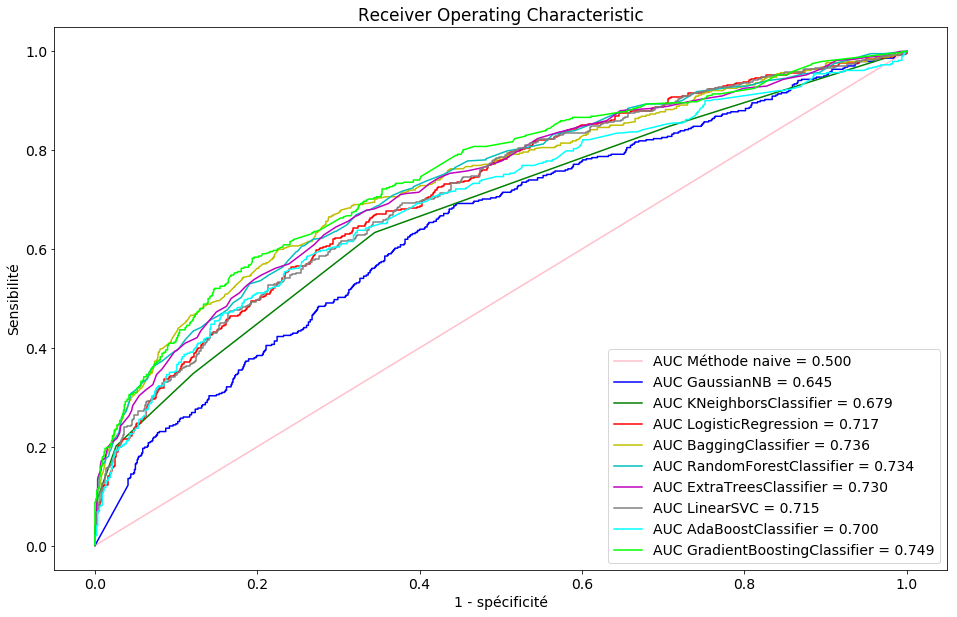

In [58]:
# Courbes ROC

plt.figure(figsize=(16,10))
plt.title('Receiver Operating Characteristic')
colors = ['pink', 'b', 'g', 'r', 'y', 'c', 'm', 'gray', 'aqua', 'lime', 'k']
for i in range(len(fpr)):
    plt.plot(fpr[i], tpr[i], color=colors[i], label = 'AUC %s = %0.3f' % (labels[i], rocs[i]))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1], linestyle='--')
plt.axis('tight')
plt.xlabel('1 - spécificité', fontsize=14)
plt.ylabel('Sensibilité', fontsize=14)
plt.show()

Notre meilleur modèle à priori est le GradientBoostingClassifier.

Allons un peu plus loin dans la recherche de ses meilleurs paramètres:

### 8.3 GradientBoostingClassifier

In [59]:
def plotclf(clf, ax):
    clf.fit(X_train, y_train)
    test_score = np.empty(len(clf.estimators_))
    for i, pred in enumerate(clf.staged_decision_function(X_test)):
        test_score[i] = clf.loss_(y_test, pred)

    train_score = np.empty(len(clf.estimators_))
    for i, pred in enumerate(clf.staged_decision_function(X_train)):
        train_score[i] = clf.loss_(y_train, pred)

    ax.plot(test_score)
    ax.plot(train_score)
    ax.legend(['test score', 'train score'])
    ax.set_title('Score en fonction de n_estimators')    

def compareScore(clf, clf2, titre):
    display(clf)
    #display(clf2)

    plt.figure(figsize=(16, 6))
    ax = plt.subplot(121)
    plotclf(clf, ax)
    ax = plt.subplot(122)
    plotclf(clf2, ax)
    plt.title(titre)


#### 8.3.1 n_estimators

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=800,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

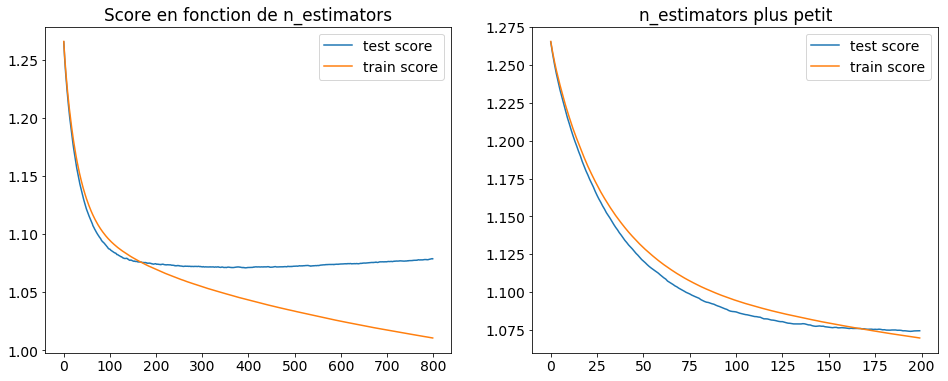

In [60]:
compareScore(GradientBoostingClassifier(n_estimators=800, learning_rate=0.05, max_depth=1), 
             GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=1),
            'n_estimators plus petit')

#### 8.3.2 learning_rate

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

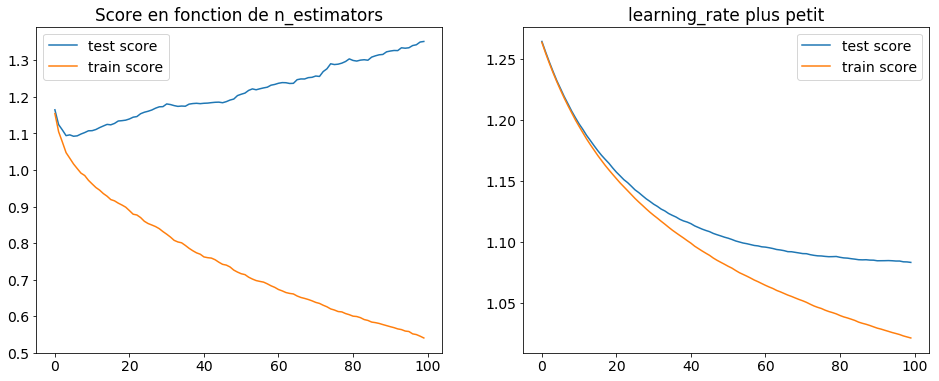

In [61]:
compareScore(GradientBoostingClassifier(n_estimators=100, learning_rate=0.5), 
             GradientBoostingClassifier(n_estimators=100, learning_rate=0.03),
             'learning_rate plus petit')

Le premier graphique comparatif entre train et test montre bien l'overfitting, lorsque le score du jeu de test se met à remonter.

Ici on overfitte beaucoup trop vite, c'est typique d'un learning rate trop grand.

On voit bien la différence sur le 2ème graphique lorsque learning_rate est mieux calibré.

#### 8.3.3 max_depth

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

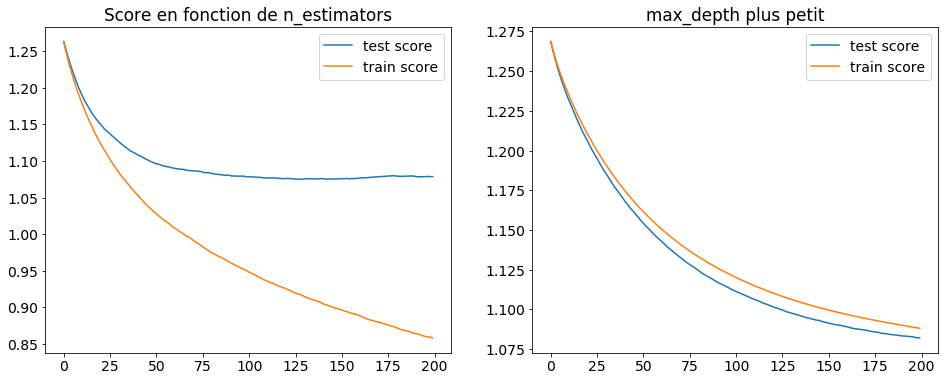

In [62]:
compareScore(GradientBoostingClassifier(n_estimators=200, learning_rate=0.03, max_depth=4), 
             GradientBoostingClassifier(n_estimators=200, learning_rate=0.03, max_depth=1),
            'max_depth plus petit')

#### 8.3.4 Les autres paramètres

In [63]:
parametres = {
#    "learning_rate":[0.2,0.1,0.05,0.03],
    "max_depth":[1,2,3,4],
    "subsample":[1.0,0.8,0.5],
    "max_features":[None,'sqrt','log2']
}
bestModel = RunModel(GradientBoostingClassifier(n_estimators=300, learning_rate=0.03, random_state=0), 'GradientBoostingClassifier', parametres)
bestModel

GradientBoostingClassifier
	AUC = 0.741


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.03, loss='deviance', max_depth=4,
              max_features='log2', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=0, subsample=0.5, verbose=0,
              warm_start=False)

In [64]:
bestModel = RunModel(GradientBoostingClassifier(n_estimators=200, learning_rate=0.03, max_depth=2, 
                        max_features='sqrt', loss='deviance', min_samples_leaf=4, 
                        subsample=0.5, random_state=0), 'GradientBoostingClassifier', {})


GradientBoostingClassifier
	AUC = 0.750


Voilà, on a maintenant un modèle optimisé pour notre recherche.

n_estimators=200 : J'ai augmenté ce paramètres jusqu'à ce que le score final se mette à diminuer, cela correspond au moment où le modèle se met à overfitter.

learning_rate=0.03 : c'est le pas de la descente de gradient

max_depth=3 : profondeur des estimateurs faibles

max_features='sqrt' : nombre max de features à considérer pour scinder un noeud, lorsqu'il est inférieur au nombre de feature cela permet de réduire la variance (mais d'augmenter le biais)

subsample=0.5 : c'est la fraction de l'échantillon à utiliser pour entrainer les estimateurs faibles. S'il est inférieur à 1 cela correspond à une descente de gradient stochastique

loss='deviance' : la valeur par défaut obtient de meilleurs résultats

#### 8.3.5 Feature Importance

Il peut être aussi très intéressant de viualiser l'importance de chaque feature, c'est ce que permet le Gradient Boosting comme on va le voir maintenant:

Text(0,0.5,'Feature Importance Score')

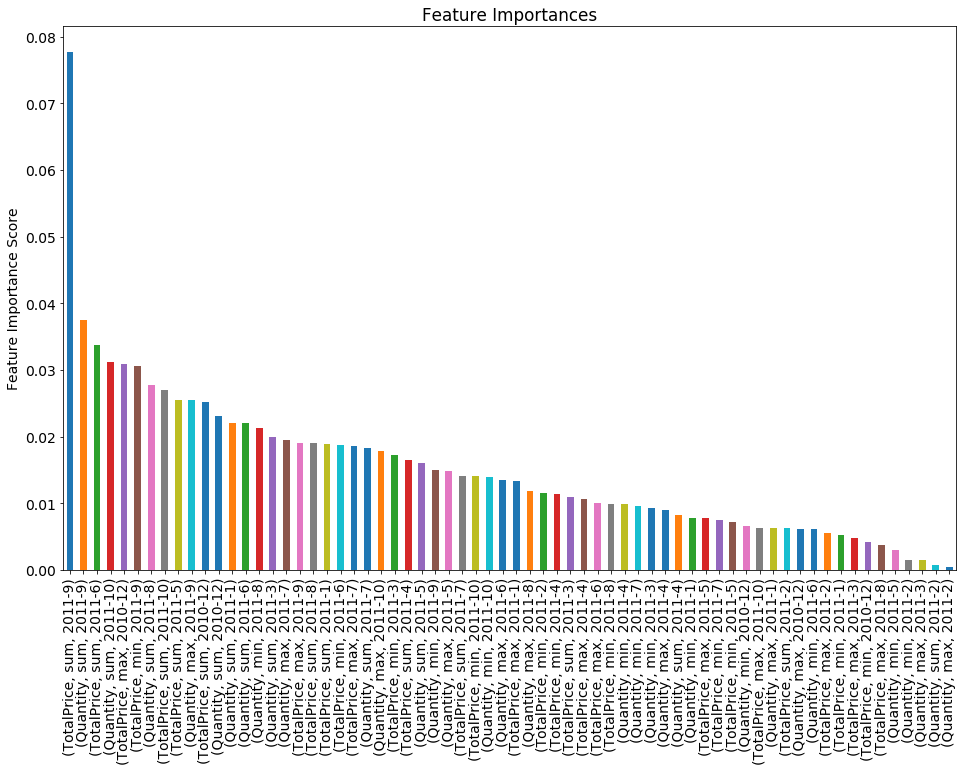

In [65]:
predictors = [x for x in X.columns]
feat_imp = pd.Series(bestModel.feature_importances_, predictors).sort_values(ascending=False)

plt.figure(figsize=(16, 10))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

Les deux features qui ont le plus d'importance sont les sommes de TotalPrice et Quantity du mois de septembre 2011.


Il est intéressant de noter que le modèle se base de manière plus importante non pas sur ce qui s'est passé le mois précédent notre target mais sur ce qui s'est passé 2 mois avant.


In [66]:
# Génération du code de visualisation d'un arbre simple avec http://webgraphviz.com/

from sklearn.tree import export_graphviz
tree0 = bestModel.estimators_[0][0]
with open("testtree.txt", "w") as f:
    f = export_graphviz(tree0, out_file=f)

### 8.4 Matrice de confusion

In [67]:
import itertools
from sklearn.metrics import confusion_matrix

In [68]:
y_pred = bestModel.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[817,  65],
       [275, 167]], dtype=int64)

Confusion matrix, without normalization
[[817  65]
 [275 167]]
Normalized confusion matrix
[[ 0.93  0.07]
 [ 0.62  0.38]]


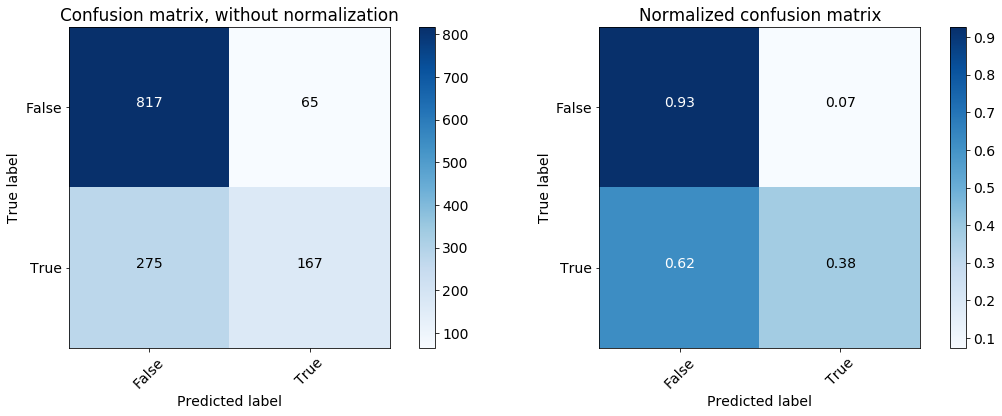

In [69]:

# Affichage de matrice de confusion
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # Possibilité de normalisation
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
class_names = ['False', 'True']
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure(figsize=(16, 6))
# Plot non-normalized confusion matrix
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')


On a quand même des soucis avec les faux négatifs, ils sont difficilies à prédire.

Ce qui semble quand même normal, en effet, certains clients achètent tous les mois, c'est facile à prédire. La majorité des autres étant plus discrets on peut parier sur 'pas d'achat'. Oui mais il y en a quand même qui ont des besoins, et c'est là que c'est difficile à prédire, d'où le fort taux de faux négatifs.